In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%config InlineBackend.figure_formats = ['svg']

# O-U process and check noise function

In [2]:
# generate OU process that should have NPS with cut freq 1/(2 pi tau)

In [3]:
def eulmaj(dX, t, X0, *args):
    assert len(t.shape) == 1, ''
    X = np.zeros(t.shape)
    X[0] = X0
    for i,t_ in tqdm(enumerate(t[1:]), total=t.shape[0] - 1):
        X[i+1] = X[i] + dX(X[i], t[i+1] - t[i], *args)
    return X

In [4]:
dX = lambda X, dt, tau, c: - 1 / tau * X * dt + np.sqrt(c) * np.random.normal(scale=np.sqrt(dt))

In [5]:
sample_frequency = 25_000
record_length = 16_384
nmbr = 20
t = np.arange(0,record_length*nmbr)/sample_frequency

In [6]:
c = 1
tau = 0.0093
std = np.sqrt(c*tau/2)
X0 = np.random.normal(scale=std)
gf = 1/(2*np.pi*tau)
print('std: ', std)
print('start value: ', X0)
print('expected GF: {} Hz'.format(gf))

std:  0.06819090848492927
start value:  0.06035062435656415
expected GF: 17.11343474106402 Hz


In [7]:
X = eulmaj(dX, t, X0, tau, c)

  0%|          | 0/327679 [00:00<?, ?it/s]

tau = 0.0093 c = 1 reclen = 16384 samfq = 25000 gives wrong by 1.0111040492273544
Simulated std  0.06810513278108647


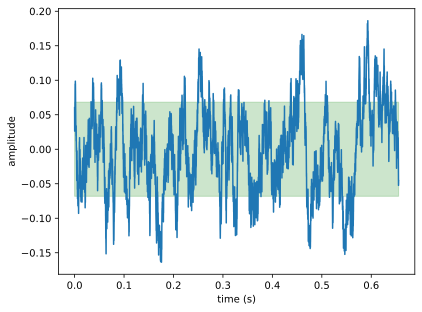

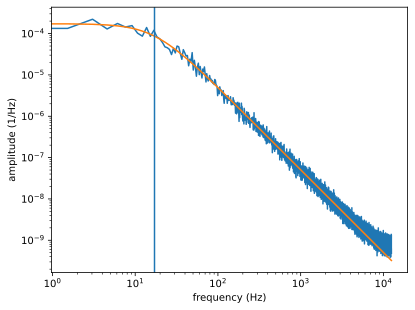

In [8]:
freq = np.fft.rfftfreq(record_length, 1/sample_frequency)
nps = np.mean(np.abs(np.fft.rfft(X.reshape(-1, record_length), axis=-1, norm='ortho'))**2, axis=0) * 2 / sample_frequency
nps_calc = 2*c*tau**2/(1 + (2*np.pi*tau*freq)**2)

print('tau = {} c = {} reclen = {} samfq = {} gives wrong by {}'.format(tau, c, record_length, sample_frequency, np.mean(nps[:1000]/nps_calc[:1000])))
print('Simulated std ', np.std(X))

plt.fill_between(t[:record_length], - std, std, alpha=0.2, color='green')
plt.plot(t[:record_length], X[:record_length])
plt.ylabel('amplitude')
plt.xlabel('time (s)')
plt.show()

plt.loglog(freq, nps)
plt.loglog(freq, nps_calc)
plt.axvline(gf)
plt.ylabel('amplitude (1/Hz)')
plt.xlabel('frequency (Hz)')
plt.show()

In [9]:
def noise_function(nps, size):
    f = np.sqrt(nps)
    f = np.array(f, dtype='complex')  # create array for frequencies
    f = np.tile(f, (size, 1))
    phases = np.random.rand(size, nps.shape[0]) * 2 * np.pi  # create random phases
    phases = np.cos(phases) + 1j * np.sin(phases)
    f *= phases
    return np.fft.irfft(f, axis=-1, norm='ortho') * np.sqrt(sample_frequency / 2)

def get_noise_bl(nps):
    noise = noise_function(nps, size=1)[0]  # in muA  #  * (1 + 0.01 * np.random.normal())
    return noise  # in V

In [10]:
X_sim = get_noise_bl(nps)

tau = 0.0093 c = 1 reclen = 16384 samfq = 25000 gives wrong by 0.9914704244064801
Reconstructed simulated std  0.06752422490272349


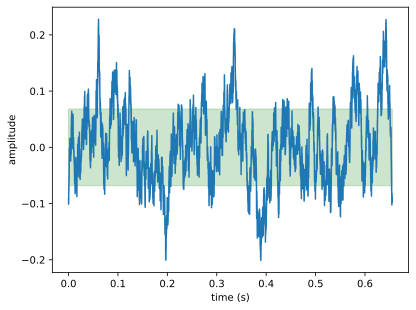

In [11]:
print('tau = {} c = {} reclen = {} samfq = {} gives wrong by {}'.format(tau, c, record_length, sample_frequency, 
                                                                        np.std(X_sim)/np.std(X)))
print('Reconstructed simulated std ', np.std(X_sim))
plt.fill_between(t[:record_length], std, -std, alpha=0.2, color='green')
plt.plot(t[:record_length], X_sim[:record_length])
plt.ylabel('amplitude')
plt.xlabel('time (s)')
plt.show()